In [5]:
import torch
import pandas as pd
import io
import nltk
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import numpy as np

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")

torch.cuda.is_available()

In [3]:
# !pip install transformers

Ucitavanje podataka

In [ ]:
df = pd.read_csv('../../data/preprocessed_sub_and_body.csv')
df["text"] = df["text"].astype(str)
df['label'] = df['label'].astype(int)
df.head()

In [5]:
df["length"] = df["text"].apply(len)
df['length'].describe()

count    11448.000000
mean       891.971960
std       2101.099586
min          1.000000
25%         35.000000
50%         93.000000
75%        937.000000
max      29191.000000
Name: length, dtype: float64

In [9]:
def plt_length():
  phishing_df = df[df["label"] == 1]
  ham_df = df[df["label"] == 0]

  _, ax = plt.subplots(figsize=(10, 4))
  sns.kdeplot(ham_df['length'], fill=True, label="Ham", color="b")
  sns.kdeplot(phishing_df['length'], fill=True, label="Phish", color="r")
  ax.set(
      xlabel="Length",
      ylabel="Density",
      title="Length of emails.",
  )
  ax.legend(loc="upper right")
  plt.show()

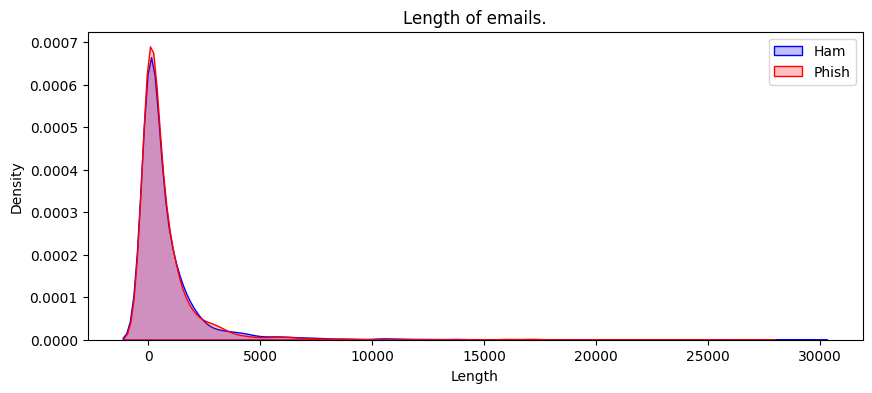

In [10]:
plt_length()

In [12]:
!pip install torchtext==0.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.9 MB/s eta 0:00:00


Za pretprocesiranje koristimo *torchtext* biblioteku, koristeci  *spaCy* za tokenizaciju.

Tran/Validation/Test split je u odnosu 70:10:20

Za velicinu rjecnika uzimamo 10000, dok je minimalna frekvencija rijeci u rjecniku 5

In [13]:
from torchtext import data
from torchtext.vocab import Vocab

# drop unnecessary columns
df = df[["text", "label"]]

# save preprocessed data to a CSV file
df.to_csv("preprocessed_cleaned.csv", index=False)

# Field is standard column, LabelField is label column
# use spacy as tokenizer
TEXT = data.Field(
    tokenize="spacy",
    tokenizer_language="en_core_web_sm",
    lower=True,
    include_lengths=True,
    batch_first=True,
)
LABEL = data.LabelField(
    dtype=torch.float, sequential=False, use_vocab=False, batch_first=True
)

# create dataset and split into train, val and test
train_data, val_data, test_data = data.TabularDataset.splits(
    path="preprocessed_cleaned.csv",
    format="csv",
    fields=[("Text", TEXT), ("Label", LABEL)],
    split_ratio=[0.7, 0.1, 0.2],
    skip_header=True,
    random_state=random.seed(42),
)

# build vocabulary, min word frequency is 5
TEXT.build_vocab(train_data, max_size=10000, min_freq=5)

## Definisanje modela. 

Prije LSTM sloja je postavljen *Embedding* sloj kako bismo dobili dense vektore

Izlaz LSTM sloja se prosleđuje na dva potpuno povezana sloja. Prvi sloj je linearni i vrši redukciju dimenzionalnosti dok drugi mapira izlaz prvog sloja na ciljnu dimenziju

*Dropout* slojevi su uključeni kako bi se sprečio overfitting nasumičnim deaktiviranjem dela neurona tokom treninga

Finalni sloj je Sigmoid aktivaciona funkcija pogodna za binarnu klasifikaciju

In [14]:
class LSTMModel(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout1, dropout2
    ):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout1 = nn.Dropout(dropout1)
        self.fc1 = nn.Linear(hidden_dim, 20)
        self.dropout2 = nn.Dropout(dropout2)
        self.fc2 = nn.Linear(20, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, x_lengths):
        embedded = self.embedding(x)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, x_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        lstm_out = hidden[-1, :, :]
        lstm_out = self.dropout1(lstm_out)
        fc1_out = self.fc1(lstm_out)
        fc1_out = self.dropout2(fc1_out)
        fc2_out = self.fc2(fc1_out)
        output = self.sigmoid(fc2_out)
        return output

Definisemo hiperparametre za *grid search* optimizaciju

In [15]:
embedding_dims = [32, 64]
hidden_dims = [100, 128]
learning_rates = [0.01, 0.001]
batch_sizes = [64, 128]
dropout_rates = [0.3, 0.4]
n_epochs = 10

best_model = None
best_val_loss = float("inf")
results = []

### Obucavanje modela

Za optimizaciju ćemo koristiti AdamW optimizer.

Za loss funkciju je odabrana *Binary Cross Entropy*

Koristimo *early stopping* kao bismo izbjegli *overfitting*

In [16]:
from tqdm.auto import tqdm
import itertools
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grid search
for embedding_dim, hidden_dim, lr, batch_size, dropout1, dropout2 in itertools.product(
        embedding_dims, hidden_dims, learning_rates, batch_sizes, dropout_rates, dropout_rates):

      # create iterators
      train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
          (train_data, val_data, test_data),
          batch_size=batch_size,
          sort_key=lambda x: len(x.body),
          sort_within_batch=True, # needed for PyTorch’s padded sequence class
          device=device
      )


      lstm_model = LSTMModel(len(TEXT.vocab), embedding_dim, hidden_dim, 1, dropout1, dropout2).to(device)
      criterion = nn.BCELoss()
      criterion = criterion.to(device)
      optimizer = optim.Adam(lstm_model.parameters(),lr=lr)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

      # early stopping criteria
      early_stopping_patience = 3
      best_epoch_val_loss = float('inf')
      epochs_no_improve = 0

      # TRAINING BLOCK
      train_losses = []
      val_losses = []

      for epoch in range(n_epochs):

          epoch_train_loss = 0
          lstm_model.train()

          with tqdm(train_iterator, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            for batch in tepoch:
                sequences, lengths = batch.body
                labels = batch.label
                optimizer.zero_grad()
                predictions = lstm_model(sequences, lengths).squeeze()
                loss = criterion(predictions, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

          train_losses.append(epoch_train_loss / len(train_iterator))

          print(f"\nTraining epoch {epoch + 1} loss: ", epoch_train_loss)
          # TRAINING BLOCK ENDS
          print("Training complete!")


          # Validation
          lstm_model.eval()
          epoch_val_loss = 0
          val_preds = []
          val_labels = []

          with torch.no_grad():
              for batch in val_iterator:
                  sequences, lengths = batch.body
                  labels = batch.label
                  predictions = lstm_model(sequences, lengths).squeeze()
                  loss = criterion(predictions, labels)
                  epoch_val_loss += loss.item()
                  val_preds.extend(predictions.cpu().numpy())
                  val_labels.extend(labels.cpu().numpy())

          val_losses.append(epoch_val_loss / len(val_iterator))

          print(f"\nValidation epoch {epoch + 1} loss: {epoch_val_loss}")

          # early stopping
          if epoch_val_loss < best_epoch_val_loss:
              best_epoch_val_loss = epoch_val_loss
              epochs_no_improve = 0
          else:
              epochs_no_improve += 1
              if epochs_no_improve >= early_stopping_patience:
                  print(f"Early stopping triggered at epoch {epoch+1}")
                  break

          # check if current model is the best
          if val_losses[-1] < best_val_loss:
              best_val_loss = val_losses[-1]
              best_model = lstm_model

          # record the results
          results.append({
              'embedding_dim': embedding_dim,
              'hidden_dim': hidden_dim,
              'lr': lr,
              'batch_size': batch_size,
              'dropout1': dropout1,
              'dropout2': dropout2,
              'n_epochs': n_epochs,
              'train_loss': train_losses[-1],
              'val_loss': val_losses[-1]
          })

best_hyperparams = min(results, key=lambda x: x['val_loss'])
print("Best Hyperparameters:")
print(best_hyperparams)


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  74.61492033302784
Training complete!

Validation epoch 1 loss: 6.868821561336517


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  34.14278755709529
Training complete!

Validation epoch 2 loss: 8.586192011833191


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.97057569399476
Training complete!

Validation epoch 3 loss: 3.858020570129156


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.792168711312115
Training complete!

Validation epoch 4 loss: 3.1639191624708474


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  8.33499026868958
Training complete!

Validation epoch 5 loss: 3.760248653241433


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  9.19362900708802
Training complete!

Validation epoch 6 loss: 4.096963512827642


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  4.592575404982199
Training complete!

Validation epoch 7 loss: 4.9257258924189955
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  75.89318345487118
Training complete!

Validation epoch 1 loss: 5.291357085108757


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  37.54391188174486
Training complete!

Validation epoch 2 loss: 5.668204724788666


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.658222749829292
Training complete!

Validation epoch 3 loss: 4.296361364424229


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  14.593955181073397
Training complete!

Validation epoch 4 loss: 4.065098115708679


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  8.278877794917207
Training complete!

Validation epoch 5 loss: 5.092542086262256


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  6.2472932651871815
Training complete!

Validation epoch 6 loss: 5.50001373142004


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.468730483495165
Training complete!

Validation epoch 7 loss: 4.367751349695027
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  68.20338892936707
Training complete!

Validation epoch 1 loss: 7.239824503660202


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  40.600975051522255
Training complete!

Validation epoch 2 loss: 5.130432832986116


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  19.513575604185462
Training complete!

Validation epoch 3 loss: 4.414050531573594


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  14.451192587497644
Training complete!

Validation epoch 4 loss: 4.317649491131306


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  11.610346058150753
Training complete!

Validation epoch 5 loss: 4.254589521326125


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  5.830824479606235
Training complete!

Validation epoch 6 loss: 6.3787606954574585


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.671937403822085
Training complete!

Validation epoch 7 loss: 6.1039630100131035


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  4.256549119112606
Training complete!

Validation epoch 8 loss: 6.1906713610515
Early stopping triggered at epoch 8


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  68.27620543539524
Training complete!

Validation epoch 1 loss: 5.506978772580624


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  35.9941063337028
Training complete!

Validation epoch 2 loss: 6.4528582990169525


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.60207209084183
Training complete!

Validation epoch 3 loss: 3.303019654005766


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  14.143232275731862
Training complete!

Validation epoch 4 loss: 3.2606605049222708


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  9.119409279082902
Training complete!

Validation epoch 5 loss: 3.184241146896966


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  6.0201741609489545
Training complete!

Validation epoch 6 loss: 3.993259864160791


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  4.958696933972533
Training complete!

Validation epoch 7 loss: 4.975939271331299


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  4.460906263499055
Training complete!

Validation epoch 8 loss: 4.4312271365197375
Early stopping triggered at epoch 8


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  35.6314537525177
Training complete!

Validation epoch 1 loss: 2.9591166228055954


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  24.69442704319954
Training complete!

Validation epoch 2 loss: 2.7840129137039185


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.661080837249756
Training complete!

Validation epoch 3 loss: 2.1216689497232437


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.486752483993769
Training complete!

Validation epoch 4 loss: 2.1321558728814125


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.553569037467241
Training complete!

Validation epoch 5 loss: 2.608040615916252


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.6118440837599337
Training complete!

Validation epoch 6 loss: 2.317415252327919
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  39.1440044939518
Training complete!

Validation epoch 1 loss: 5.730329215526581


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  25.41917361319065
Training complete!

Validation epoch 2 loss: 2.3124792128801346


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.855093566700816
Training complete!

Validation epoch 3 loss: 2.212426118552685


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.472365809604526
Training complete!

Validation epoch 4 loss: 2.155437044799328


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.545810893643647
Training complete!

Validation epoch 5 loss: 2.209125831723213


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.157997797243297
Training complete!

Validation epoch 6 loss: 1.7714728340506554


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  4.120653752237558
Training complete!

Validation epoch 7 loss: 2.1323217414319515


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  3.1286119079450145
Training complete!

Validation epoch 8 loss: 2.5163236930966377


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  2.9395354978041723
Training complete!

Validation epoch 9 loss: 2.715132474899292
Early stopping triggered at epoch 9


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  37.790392994880676
Training complete!

Validation epoch 1 loss: 3.1859095692634583


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.669229224324226
Training complete!

Validation epoch 2 loss: 2.268011398613453


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.192707005888224
Training complete!

Validation epoch 3 loss: 1.9145382195711136


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.792080525308847
Training complete!

Validation epoch 4 loss: 3.044014632701874


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.6028068121522665
Training complete!

Validation epoch 5 loss: 2.3051241002976894


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.7035100751090795
Training complete!

Validation epoch 6 loss: 2.756753623485565
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  41.1718068420887
Training complete!

Validation epoch 1 loss: 3.53595569729805


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  22.673203967511654
Training complete!

Validation epoch 2 loss: 2.869915008544922


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.120609775185585
Training complete!

Validation epoch 3 loss: 2.029007986187935


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.408608324825764
Training complete!

Validation epoch 4 loss: 2.3456714898347855


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.607680638320744
Training complete!

Validation epoch 5 loss: 2.183190830051899


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  6.130759037099779
Training complete!

Validation epoch 6 loss: 1.830059103667736


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.629428176674992
Training complete!

Validation epoch 7 loss: 2.3572384789586067


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  5.886385974707082
Training complete!

Validation epoch 8 loss: 2.2558053359389305


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  2.92458671197528
Training complete!

Validation epoch 9 loss: 2.4293394908308983
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  80.30277687311172
Training complete!

Validation epoch 1 loss: 6.887310668826103


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  68.2871736139059
Training complete!

Validation epoch 2 loss: 16.204481154680252


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  91.31860360503197
Training complete!

Validation epoch 3 loss: 10.459201961755753


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  80.95977327227592
Training complete!

Validation epoch 4 loss: 9.177226781845093
Early stopping triggered at epoch 4


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  81.60759170353413
Training complete!

Validation epoch 1 loss: 9.894882768392563


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  62.809587359428406
Training complete!

Validation epoch 2 loss: 6.784034758806229


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  51.25838823616505
Training complete!

Validation epoch 3 loss: 5.494176462292671


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  55.03835477679968
Training complete!

Validation epoch 4 loss: 5.751819968223572


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  40.462837524712086
Training complete!

Validation epoch 5 loss: 5.113798998296261


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  41.819441793486476
Training complete!

Validation epoch 6 loss: 5.7469679564237595


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  40.19785983860493
Training complete!

Validation epoch 7 loss: 5.295198932290077


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  27.269881833344698
Training complete!

Validation epoch 8 loss: 4.39074819907546


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  23.91933954320848
Training complete!

Validation epoch 9 loss: 4.0405688770115376


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  19.784714065492153
Training complete!

Validation epoch 10 loss: 3.86503691598773


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  78.87495639175177
Training complete!

Validation epoch 1 loss: 7.622777730226517


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  66.98927825689316
Training complete!

Validation epoch 2 loss: 7.426381349563599


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  50.52762459218502
Training complete!

Validation epoch 3 loss: 5.8563202023506165


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  44.87575928866863
Training complete!

Validation epoch 4 loss: 5.678792580962181


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  40.53927933424711
Training complete!

Validation epoch 5 loss: 5.362100958824158


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  32.38232480362058
Training complete!

Validation epoch 6 loss: 5.295315269380808


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  27.55774004943669
Training complete!

Validation epoch 7 loss: 4.997704926878214


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  23.84855038113892
Training complete!

Validation epoch 8 loss: 4.880739584565163


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  25.37053444609046
Training complete!

Validation epoch 9 loss: 4.5882512256503105


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  20.819810764864087
Training complete!

Validation epoch 10 loss: 5.361551024019718


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  83.5328496992588
Training complete!

Validation epoch 1 loss: 7.496145784854889


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  53.461235612630844
Training complete!

Validation epoch 2 loss: 5.805656887590885


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  51.06967804580927
Training complete!

Validation epoch 3 loss: 6.31922122836113


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  39.654788341373205
Training complete!

Validation epoch 4 loss: 4.777421660721302


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  31.4915759190917
Training complete!

Validation epoch 5 loss: 4.491879967972636


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  28.106875142082572
Training complete!

Validation epoch 6 loss: 5.591802600771189


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  26.179110498167574
Training complete!

Validation epoch 7 loss: 4.554768739268184


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  20.53643533308059
Training complete!

Validation epoch 8 loss: 4.123660866171122


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  18.387837091926485
Training complete!

Validation epoch 9 loss: 4.439409697428346


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  16.836513152811676
Training complete!

Validation epoch 10 loss: 4.655043244361877


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  44.78902670741081
Training complete!

Validation epoch 1 loss: 4.355414718389511


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  33.99147832393646
Training complete!

Validation epoch 2 loss: 3.998527228832245


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  26.596150144934654
Training complete!

Validation epoch 3 loss: 3.022781938314438


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  27.783723071217537
Training complete!

Validation epoch 4 loss: 3.280598998069763


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.64393726736307
Training complete!

Validation epoch 5 loss: 3.094505399465561


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.88685266673565
Training complete!

Validation epoch 6 loss: 2.55351859331131


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  17.173117615282536
Training complete!

Validation epoch 7 loss: 2.491269111633301


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.783766508102417
Training complete!

Validation epoch 8 loss: 2.4254502654075623


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  14.580895006656647
Training complete!

Validation epoch 9 loss: 2.458411328494549


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  12.214651206508279
Training complete!

Validation epoch 10 loss: 2.4061538353562355


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  45.90656369924545
Training complete!

Validation epoch 1 loss: 4.876526117324829


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  33.16132991015911
Training complete!

Validation epoch 2 loss: 3.8594404757022858


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  28.036043629050255
Training complete!

Validation epoch 3 loss: 3.455948993563652


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  27.964549779891968
Training complete!

Validation epoch 4 loss: 3.344494938850403


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.525721073150635
Training complete!

Validation epoch 5 loss: 3.0161881297826767


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  18.813856936991215
Training complete!

Validation epoch 6 loss: 2.751714274287224


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.98618583381176
Training complete!

Validation epoch 7 loss: 2.4715153500437737


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  15.1551632322371
Training complete!

Validation epoch 8 loss: 2.3234842121601105


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  14.302475709468126
Training complete!

Validation epoch 9 loss: 2.3764168173074722


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  12.439341187477112
Training complete!

Validation epoch 10 loss: 2.3860140815377235


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  45.88271823525429
Training complete!

Validation epoch 1 loss: 4.746238052845001


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  33.593421548604965
Training complete!

Validation epoch 2 loss: 3.870600789785385


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  28.564653784036636
Training complete!

Validation epoch 3 loss: 3.072105050086975


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  25.70717604458332
Training complete!

Validation epoch 4 loss: 3.2040033042430878


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  21.336585581302643
Training complete!

Validation epoch 5 loss: 2.575073018670082


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  17.80985437333584
Training complete!

Validation epoch 6 loss: 2.4280072450637817


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  17.127520099282265
Training complete!

Validation epoch 7 loss: 4.384602218866348


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  20.935300759971142
Training complete!

Validation epoch 8 loss: 2.2486565858125687


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  15.072114396840334
Training complete!

Validation epoch 9 loss: 2.1760401353240013


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  11.957752346992493
Training complete!

Validation epoch 10 loss: 2.1385249942541122


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  45.668917804956436
Training complete!

Validation epoch 1 loss: 4.287549048662186


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  36.90169385075569
Training complete!

Validation epoch 2 loss: 3.9420550167560577


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  31.25296512246132
Training complete!

Validation epoch 3 loss: 3.336378037929535


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  28.88988010585308
Training complete!

Validation epoch 4 loss: 4.049367845058441


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  28.32678297162056
Training complete!

Validation epoch 5 loss: 3.072742447257042


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  22.00949876010418
Training complete!

Validation epoch 6 loss: 2.913787916302681


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.796401992440224
Training complete!

Validation epoch 7 loss: 2.60588201880455


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  16.331285156309605
Training complete!

Validation epoch 8 loss: 2.5812718719244003


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  16.361913740634918
Training complete!

Validation epoch 9 loss: 2.5408338457345963


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.020291861146688
Training complete!

Validation epoch 10 loss: 2.4538400173187256


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  70.14160957187414
Training complete!

Validation epoch 1 loss: 5.874460607767105


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  34.5411120839417
Training complete!

Validation epoch 2 loss: 4.569736905395985


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  27.108792952261865
Training complete!

Validation epoch 3 loss: 3.871068784967065


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  15.627228405326605
Training complete!

Validation epoch 4 loss: 4.431746229529381


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  10.740445511648431
Training complete!

Validation epoch 5 loss: 4.550052220292855


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  5.508018722466659
Training complete!

Validation epoch 6 loss: 4.704382728785276
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  66.35383535921574
Training complete!

Validation epoch 1 loss: 5.368529476225376


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  33.50851992890239
Training complete!

Validation epoch 2 loss: 4.837575405836105


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  19.690643263515085
Training complete!

Validation epoch 3 loss: 3.790450941771269


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  11.692759574623778
Training complete!

Validation epoch 4 loss: 3.570131789892912


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  8.224440858175512
Training complete!

Validation epoch 5 loss: 3.586471350165084


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  5.007980634851265
Training complete!

Validation epoch 6 loss: 5.056393933482468


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  16.315318188862875
Training complete!

Validation epoch 7 loss: 3.9601445782463998
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  65.40384255349636
Training complete!

Validation epoch 1 loss: 6.051362261176109


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  33.19418592378497
Training complete!

Validation epoch 2 loss: 5.350708842277527


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.864337587729096
Training complete!

Validation epoch 3 loss: 4.10489154048264


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  14.9372238679789
Training complete!

Validation epoch 4 loss: 3.64137836988084


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  13.81830938323401
Training complete!

Validation epoch 5 loss: 4.88867312669754


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  7.925571858184412
Training complete!

Validation epoch 6 loss: 4.556778288068017


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  6.036813750601141
Training complete!

Validation epoch 7 loss: 4.955710126785561
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  74.53473659604788
Training complete!

Validation epoch 1 loss: 6.758385121822357


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  38.3976141884923
Training complete!

Validation epoch 2 loss: 4.134371347725391


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  23.242154283449054
Training complete!

Validation epoch 3 loss: 3.6645175255835056


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.070501390844584
Training complete!

Validation epoch 4 loss: 3.6406354270875454


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  9.270229918765835
Training complete!

Validation epoch 5 loss: 4.19734561961377


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  7.056728775263764
Training complete!

Validation epoch 6 loss: 4.801675509952474


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  4.3177695702179335
Training complete!

Validation epoch 7 loss: 4.7641533997957595
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  38.34320902824402
Training complete!

Validation epoch 1 loss: 3.460920423269272


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.59076479077339
Training complete!

Validation epoch 2 loss: 3.012796863913536


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  13.078640984371305
Training complete!

Validation epoch 3 loss: 1.8158651143312454


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.959230080246925
Training complete!

Validation epoch 4 loss: 2.0035698860883713


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.08904421236366
Training complete!

Validation epoch 5 loss: 2.4007625691592693


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.234387352364138
Training complete!

Validation epoch 6 loss: 2.1077840831130743
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  39.83822125196457
Training complete!

Validation epoch 1 loss: 3.1344324350357056


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.16929203271866
Training complete!

Validation epoch 2 loss: 2.453820899128914


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.873943846672773
Training complete!

Validation epoch 3 loss: 2.5495804622769356


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.949103213846684
Training complete!

Validation epoch 4 loss: 2.1239303946495056


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.445540110580623
Training complete!

Validation epoch 5 loss: 2.3317391723394394


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.851067271316424
Training complete!

Validation epoch 6 loss: 2.2336012683808804


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.0590894618071616
Training complete!

Validation epoch 7 loss: 2.430230761412531
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.27703981101513
Training complete!

Validation epoch 1 loss: 3.2962597459554672


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  19.217617474496365
Training complete!

Validation epoch 2 loss: 2.369520902633667


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  11.593666456639767
Training complete!

Validation epoch 3 loss: 2.1625774055719376


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.590617739595473
Training complete!

Validation epoch 4 loss: 2.183055490255356


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.2021248487289995
Training complete!

Validation epoch 5 loss: 2.1446727514266968


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  5.378231527283788
Training complete!

Validation epoch 6 loss: 2.183723881840706


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  5.255031157983467
Training complete!

Validation epoch 7 loss: 2.5750626511871815


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  2.66982421267312
Training complete!

Validation epoch 8 loss: 2.6110550686717033
Early stopping triggered at epoch 8


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  35.28897735476494
Training complete!

Validation epoch 1 loss: 3.105849951505661


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  18.739477410912514
Training complete!

Validation epoch 2 loss: 2.334508404135704


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  12.276119403541088
Training complete!

Validation epoch 3 loss: 2.0837993659079075


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.324199488386512
Training complete!

Validation epoch 4 loss: 2.2285710647702217


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.278487647650763
Training complete!

Validation epoch 5 loss: 2.204968474805355


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.4491576143773273
Training complete!

Validation epoch 6 loss: 2.118067681789398
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  76.24119341373444
Training complete!

Validation epoch 1 loss: 6.942661672830582


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  56.48413220047951
Training complete!

Validation epoch 2 loss: 6.322434335947037


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  46.9269595593214
Training complete!

Validation epoch 3 loss: 6.2241673320531845


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  45.480313040316105
Training complete!

Validation epoch 4 loss: 4.699179533869028


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  44.5360956415534
Training complete!

Validation epoch 5 loss: 4.493523754179478


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  30.301157949492335
Training complete!

Validation epoch 6 loss: 5.281668454408646


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  26.244256054982543
Training complete!

Validation epoch 7 loss: 4.218010017648339


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  24.29133692663163
Training complete!

Validation epoch 8 loss: 4.097660392522812


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  21.354683816432953
Training complete!

Validation epoch 9 loss: 4.0394101943820715


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  17.634427091339603
Training complete!

Validation epoch 10 loss: 3.8750668121501803


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  84.89357008039951
Training complete!

Validation epoch 1 loss: 8.65329372882843


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  64.23313710093498
Training complete!

Validation epoch 2 loss: 6.849389672279358


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  51.49137109518051
Training complete!

Validation epoch 3 loss: 8.986100152134895


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  44.33561301231384
Training complete!

Validation epoch 4 loss: 5.317956984043121


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  38.73583033680916
Training complete!

Validation epoch 5 loss: 5.421523109078407


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  35.212557792663574
Training complete!

Validation epoch 6 loss: 4.905366815626621


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  33.548781991004944
Training complete!

Validation epoch 7 loss: 5.322934374213219


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  27.51713677495718
Training complete!

Validation epoch 8 loss: 5.123916257172823


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  23.12092750519514
Training complete!

Validation epoch 9 loss: 5.725200608372688
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  85.03236129879951
Training complete!

Validation epoch 1 loss: 8.824676483869553


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  58.34772199392319
Training complete!

Validation epoch 2 loss: 6.233152255415916


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  48.39123724400997
Training complete!

Validation epoch 3 loss: 6.160714358091354


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  48.831808142364025
Training complete!

Validation epoch 4 loss: 5.018357083201408


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  34.069643065333366
Training complete!

Validation epoch 5 loss: 4.713168207556009


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  29.537059254013002
Training complete!

Validation epoch 6 loss: 4.313085066154599


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  27.771046809386462
Training complete!

Validation epoch 7 loss: 4.223325781524181


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  23.121769435238093
Training complete!

Validation epoch 8 loss: 4.316534178331494


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  25.444573945365846
Training complete!

Validation epoch 9 loss: 4.122062232345343


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  20.30638364702463
Training complete!

Validation epoch 10 loss: 4.3899020394310355


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  85.59522715210915
Training complete!

Validation epoch 1 loss: 8.29479792714119


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  58.47031873464584
Training complete!

Validation epoch 2 loss: 6.52073609828949


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  46.31420670449734
Training complete!

Validation epoch 3 loss: 5.206087723374367


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  42.360457610338926
Training complete!

Validation epoch 4 loss: 5.070738296955824


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  31.455793868750334
Training complete!

Validation epoch 5 loss: 4.584418095648289


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  27.37142775580287
Training complete!

Validation epoch 6 loss: 4.509314075112343


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  25.966322112828493
Training complete!

Validation epoch 7 loss: 4.499765712767839


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  20.544629997573793
Training complete!

Validation epoch 8 loss: 4.7988364566117525


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  18.027259971480817
Training complete!

Validation epoch 9 loss: 4.65043403301388


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  16.024328684434295
Training complete!

Validation epoch 10 loss: 5.065344392322004
Early stopping triggered at epoch 10


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  45.49935832619667
Training complete!

Validation epoch 1 loss: 4.597119450569153


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  31.60403835773468
Training complete!

Validation epoch 2 loss: 6.297792583703995


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  34.71785253286362
Training complete!

Validation epoch 3 loss: 3.895891547203064


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  25.487739086151123
Training complete!

Validation epoch 4 loss: 3.5246255695819855


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  23.24626612663269
Training complete!

Validation epoch 5 loss: 3.176764965057373


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.61736274510622
Training complete!

Validation epoch 6 loss: 2.6936291456222534


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.223739609122276
Training complete!

Validation epoch 7 loss: 5.663577288389206


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  30.08477845788002
Training complete!

Validation epoch 8 loss: 2.786396861076355


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  18.312839694321156
Training complete!

Validation epoch 9 loss: 2.586084395647049


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  16.87722661346197
Training complete!

Validation epoch 10 loss: 2.6356118619441986


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  46.614280581474304
Training complete!

Validation epoch 1 loss: 5.558305323123932


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  35.84639582037926
Training complete!

Validation epoch 2 loss: 3.5740333199501038


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  28.073986619710922
Training complete!

Validation epoch 3 loss: 3.2566218227148056


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  28.63096956908703
Training complete!

Validation epoch 4 loss: 3.7479297518730164


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  25.872558906674385
Training complete!

Validation epoch 5 loss: 2.645979017019272


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.151677407324314
Training complete!

Validation epoch 6 loss: 2.4435428231954575


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  21.05513896048069
Training complete!

Validation epoch 7 loss: 3.356920540332794


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  20.865351229906082
Training complete!

Validation epoch 8 loss: 2.3387224599719048


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  15.692999698221684
Training complete!

Validation epoch 9 loss: 2.2674165591597557


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.810658507049084
Training complete!

Validation epoch 10 loss: 2.4389421194791794


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  43.654429733753204
Training complete!

Validation epoch 1 loss: 5.714708894491196


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  32.692235603928566
Training complete!

Validation epoch 2 loss: 5.628216475248337


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  37.19899356365204
Training complete!

Validation epoch 3 loss: 4.201455056667328


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  30.560553163290024
Training complete!

Validation epoch 4 loss: 3.206580698490143


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  25.75101988017559
Training complete!

Validation epoch 5 loss: 2.8811194747686386


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  22.990308985114098
Training complete!

Validation epoch 6 loss: 3.3499282002449036


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  20.115350037813187
Training complete!

Validation epoch 7 loss: 2.8382136672735214


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  18.246133878827095
Training complete!

Validation epoch 8 loss: 2.5189947187900543


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  17.112154461443424
Training complete!

Validation epoch 9 loss: 2.5167813450098038


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.38813429325819
Training complete!

Validation epoch 10 loss: 2.434409722685814


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  45.631854712963104
Training complete!

Validation epoch 1 loss: 4.580504953861237


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  32.922071903944016
Training complete!

Validation epoch 2 loss: 3.958287000656128


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  28.136038690805435
Training complete!

Validation epoch 3 loss: 3.2360169887542725


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  29.308799639344215
Training complete!

Validation epoch 4 loss: 3.4996244311332703


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  22.588161036372185
Training complete!

Validation epoch 5 loss: 3.089705303311348


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  24.27226373553276
Training complete!

Validation epoch 6 loss: 2.8951721638441086


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.07291353493929
Training complete!

Validation epoch 7 loss: 2.711663603782654


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  16.67768143862486
Training complete!

Validation epoch 8 loss: 2.4882092624902725


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  28.67889828979969
Training complete!

Validation epoch 9 loss: 2.872856020927429


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  16.19708376377821
Training complete!

Validation epoch 10 loss: 2.519878461956978


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  58.99733514338732
Training complete!

Validation epoch 1 loss: 4.680935308337212


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  27.1516274176538
Training complete!

Validation epoch 2 loss: 3.3707221001386642


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.991826723096892
Training complete!

Validation epoch 3 loss: 3.9995043762028217


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.030366113467608
Training complete!

Validation epoch 4 loss: 3.3480774080380797


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.276852279755985
Training complete!

Validation epoch 5 loss: 4.6082898862077855


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  5.5579293422197225
Training complete!

Validation epoch 6 loss: 5.264468685723841


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  5.92585109891661
Training complete!

Validation epoch 7 loss: 5.14083513681544
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  62.846320040524006
Training complete!

Validation epoch 1 loss: 5.392135173082352


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  31.90535288490355
Training complete!

Validation epoch 2 loss: 3.8715061163529754


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.704387706704438
Training complete!

Validation epoch 3 loss: 4.362584822811186


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.062942662509158
Training complete!

Validation epoch 4 loss: 5.397224212065339


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.967321181553416
Training complete!

Validation epoch 5 loss: 4.922323831357062
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  62.2425651922822
Training complete!

Validation epoch 1 loss: 4.8066932410001755


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  36.10091285035014
Training complete!

Validation epoch 2 loss: 3.8853686936199665


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  16.622138020582497
Training complete!

Validation epoch 3 loss: 3.856475230306387


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.576609435025603
Training complete!

Validation epoch 4 loss: 3.8350548786111176


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.346240014070645
Training complete!

Validation epoch 5 loss: 4.247188861481845


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.363037510040158
Training complete!

Validation epoch 6 loss: 5.170163261238486


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  9.347905529939453
Training complete!

Validation epoch 7 loss: 6.583607567939907
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  61.42055681347847
Training complete!

Validation epoch 1 loss: 4.935951575636864


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.6006098985672
Training complete!

Validation epoch 2 loss: 3.7850436940789223


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  18.31700699031353
Training complete!

Validation epoch 3 loss: 4.675294471904635


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  10.065606974996626
Training complete!

Validation epoch 4 loss: 3.844999643129995


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.79057700256817
Training complete!

Validation epoch 5 loss: 4.897328737686621
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  32.387304842472076
Training complete!

Validation epoch 1 loss: 2.3091966211795807


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  14.392690937966108
Training complete!

Validation epoch 2 loss: 1.775826781988144


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  8.431570913642645
Training complete!

Validation epoch 3 loss: 1.788368545472622


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.137877628207207
Training complete!

Validation epoch 4 loss: 1.9511496797204018


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.101856700319331
Training complete!

Validation epoch 5 loss: 2.214480571448803
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.416082978248596
Training complete!

Validation epoch 1 loss: 3.0175000727176666


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  20.146659590303898
Training complete!

Validation epoch 2 loss: 3.6619381606578827


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  18.04227176308632
Training complete!

Validation epoch 3 loss: 2.1012261733412743


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  10.403474386781454
Training complete!

Validation epoch 4 loss: 1.9497507251799107


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  6.265521610155702
Training complete!

Validation epoch 5 loss: 2.1735638231039047


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.909417951479554
Training complete!

Validation epoch 6 loss: 2.1506216898560524


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.376100132940337
Training complete!

Validation epoch 7 loss: 2.4198871478438377
Early stopping triggered at epoch 7


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  33.10692444443703
Training complete!

Validation epoch 1 loss: 2.6839016377925873


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  15.982524782419205
Training complete!

Validation epoch 2 loss: 1.933634601533413


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.41881700977683
Training complete!

Validation epoch 3 loss: 2.2404888719320297


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.5486245905049145
Training complete!

Validation epoch 4 loss: 2.2647682204842567


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.340535439783707
Training complete!

Validation epoch 5 loss: 2.6235226690769196
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.94037812948227
Training complete!

Validation epoch 1 loss: 2.9492037147283554


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  17.82704345136881
Training complete!

Validation epoch 2 loss: 2.0163812190294266


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  9.546983329579234
Training complete!

Validation epoch 3 loss: 2.2114745527505875


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.462723665870726
Training complete!

Validation epoch 4 loss: 2.1623135544359684


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.886754740029573
Training complete!

Validation epoch 5 loss: 2.2491241097450256
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  77.82386207580566
Training complete!

Validation epoch 1 loss: 7.195989400148392


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  60.24857842922211
Training complete!

Validation epoch 2 loss: 7.800053149461746


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  49.48695661127567
Training complete!

Validation epoch 3 loss: 8.638799265027046


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  37.927933357656
Training complete!

Validation epoch 4 loss: 5.411287106573582


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  37.307990539819
Training complete!

Validation epoch 5 loss: 6.2676356583833694


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  28.737877000123262
Training complete!

Validation epoch 6 loss: 4.481281988322735


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  21.935621606186032
Training complete!

Validation epoch 7 loss: 4.8506061136722565


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  20.304207078181207
Training complete!

Validation epoch 8 loss: 4.3941860273480415


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  16.020672512240708
Training complete!

Validation epoch 9 loss: 4.700950980186462


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  14.281489272601902
Training complete!

Validation epoch 10 loss: 4.416799230501056


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  78.88387753069401
Training complete!

Validation epoch 1 loss: 7.771425157785416


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  51.98132145404816
Training complete!

Validation epoch 2 loss: 6.306666374206543


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  40.89019861072302
Training complete!

Validation epoch 3 loss: 5.015123911201954


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  33.21569821983576
Training complete!

Validation epoch 4 loss: 5.270581036806107


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  25.72759954072535
Training complete!

Validation epoch 5 loss: 4.469573479145765


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  19.73684757621959
Training complete!

Validation epoch 6 loss: 4.145482076797634


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  15.97577359341085
Training complete!

Validation epoch 7 loss: 4.506503857206553


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  18.06438081408851
Training complete!

Validation epoch 8 loss: 4.571340720169246


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  12.342513039242476
Training complete!

Validation epoch 9 loss: 4.52427645213902
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  75.01852299273014
Training complete!

Validation epoch 1 loss: 6.042972780764103


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  44.64043468609452
Training complete!

Validation epoch 2 loss: 4.8627850860357285


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  36.197534792125225
Training complete!

Validation epoch 3 loss: 4.696048311889172


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  31.80957828462124
Training complete!

Validation epoch 4 loss: 4.959090784192085


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  26.760109988972545
Training complete!

Validation epoch 5 loss: 3.934977415949106


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  20.402302543632686
Training complete!

Validation epoch 6 loss: 3.7805671226233244


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  17.091902248561382
Training complete!

Validation epoch 7 loss: 4.104173980653286


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.02166408021003
Training complete!

Validation epoch 8 loss: 4.146064475178719


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  17.725539994891733
Training complete!

Validation epoch 9 loss: 4.865102142095566
Early stopping triggered at epoch 9


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  83.07416096329689
Training complete!

Validation epoch 1 loss: 8.426743298768997


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  59.11295173317194
Training complete!

Validation epoch 2 loss: 5.933286190032959


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  45.27830481529236
Training complete!

Validation epoch 3 loss: 6.891935333609581


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  36.92912968620658
Training complete!

Validation epoch 4 loss: 4.43416203930974


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  27.454924903810024
Training complete!

Validation epoch 5 loss: 4.113646423444152


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  22.89938290324062
Training complete!

Validation epoch 6 loss: 3.8565371427685022


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.21249068668112
Training complete!

Validation epoch 7 loss: 4.194859832525253


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  15.597525423392653
Training complete!

Validation epoch 8 loss: 4.277367163449526


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  13.892755346838385
Training complete!

Validation epoch 9 loss: 4.295373562257737
Early stopping triggered at epoch 9


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  44.20147228240967
Training complete!

Validation epoch 1 loss: 4.65372371673584


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  30.566822469234467
Training complete!

Validation epoch 2 loss: 3.5640823245048523


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  25.619166895747185
Training complete!

Validation epoch 3 loss: 2.979544758796692


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.800153344869614
Training complete!

Validation epoch 4 loss: 2.6252149641513824


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  19.477190159261227
Training complete!

Validation epoch 5 loss: 2.4732273519039154


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  15.317239128053188
Training complete!

Validation epoch 6 loss: 2.2612244114279747


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.843803942203522
Training complete!

Validation epoch 7 loss: 2.2758080661296844


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.136940671131015
Training complete!

Validation epoch 8 loss: 2.2173557355999947


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.647535522468388
Training complete!

Validation epoch 9 loss: 2.28523588180542


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.997084680013359
Training complete!

Validation epoch 10 loss: 2.4029547721147537


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  44.05078026652336
Training complete!

Validation epoch 1 loss: 4.192102700471878


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  30.803851947188377
Training complete!

Validation epoch 2 loss: 3.5669987201690674


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  25.07463951408863
Training complete!

Validation epoch 3 loss: 2.7010982781648636


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  21.610495448112488
Training complete!

Validation epoch 4 loss: 2.5062677040696144


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  19.104337207973003
Training complete!

Validation epoch 5 loss: 3.132345825433731


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  16.180696446448565
Training complete!

Validation epoch 6 loss: 2.193097397685051


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.503386117517948
Training complete!

Validation epoch 7 loss: 2.2077793329954147


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  14.36530496366322
Training complete!

Validation epoch 8 loss: 2.398209825158119


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  14.437963124364614
Training complete!

Validation epoch 9 loss: 2.4469125270843506
Early stopping triggered at epoch 9


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  42.66415670514107
Training complete!

Validation epoch 1 loss: 3.859475016593933


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  30.220489382743835
Training complete!

Validation epoch 2 loss: 3.602275103330612


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  25.236951529979706
Training complete!

Validation epoch 3 loss: 2.961611896753311


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.20504978299141
Training complete!

Validation epoch 4 loss: 2.6228001564741135


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  17.162418834865093
Training complete!

Validation epoch 5 loss: 2.774400532245636


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.796410202980042
Training complete!

Validation epoch 6 loss: 2.332628518342972


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.103620879352093
Training complete!

Validation epoch 7 loss: 2.456676408648491


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.335648307576776
Training complete!

Validation epoch 8 loss: 2.1549365669488907


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.593848364893347
Training complete!

Validation epoch 9 loss: 2.387136861681938


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.941718317568302
Training complete!

Validation epoch 10 loss: 2.208935245871544


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  43.566890865564346
Training complete!

Validation epoch 1 loss: 3.744350552558899


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  40.92005541920662
Training complete!

Validation epoch 2 loss: 4.59056743979454


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  36.817902356386185
Training complete!

Validation epoch 3 loss: 4.29501137137413


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  33.573643922805786
Training complete!

Validation epoch 4 loss: 3.8743065297603607
Early stopping triggered at epoch 4


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  72.78033958375454
Training complete!

Validation epoch 1 loss: 4.861277692019939


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  29.64352458715439
Training complete!

Validation epoch 2 loss: 3.875652415677905


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  20.09471279894933
Training complete!

Validation epoch 3 loss: 4.153554881922901


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  12.025967497145757
Training complete!

Validation epoch 4 loss: 3.5962705882266164


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  17.09115641610697
Training complete!

Validation epoch 5 loss: 3.7940600402653217


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  6.7782970673870295
Training complete!

Validation epoch 6 loss: 3.992046329192817


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.1870363592752255
Training complete!

Validation epoch 7 loss: 5.031448343870579
Early stopping triggered at epoch 7


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  64.18892619013786
Training complete!

Validation epoch 1 loss: 4.507517695426941


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  29.31182472407818
Training complete!

Validation epoch 2 loss: 3.816011019051075


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.117324407212436
Training complete!

Validation epoch 3 loss: 3.800721733830869


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  10.07225627079606
Training complete!

Validation epoch 4 loss: 4.169705208390951


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.209383108187467
Training complete!

Validation epoch 5 loss: 4.671673170756549


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  7.211694201017963
Training complete!

Validation epoch 6 loss: 5.62243492831476
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  63.01568851619959
Training complete!

Validation epoch 1 loss: 5.46068263053894


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  27.30506418272853
Training complete!

Validation epoch 2 loss: 4.595552355051041


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  22.309799421112984
Training complete!

Validation epoch 3 loss: 5.495545648038387


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  14.905346928630024
Training complete!

Validation epoch 4 loss: 5.4412475898861885


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  7.716156957932981
Training complete!

Validation epoch 5 loss: 4.602195833111182
Early stopping triggered at epoch 5


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  65.72415612637997
Training complete!

Validation epoch 1 loss: 7.236944288015366


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  30.632011331617832
Training complete!

Validation epoch 2 loss: 4.020244222134352


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  15.480252783279866
Training complete!

Validation epoch 3 loss: 3.7275655418634415


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  9.728717273799703
Training complete!

Validation epoch 4 loss: 5.012975391000509


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  8.082343170768581
Training complete!

Validation epoch 5 loss: 4.683959656860679


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.986081355513306
Training complete!

Validation epoch 6 loss: 4.684275890875142
Early stopping triggered at epoch 6


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  36.46183155477047
Training complete!

Validation epoch 1 loss: 3.059527814388275


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  16.43506109714508
Training complete!

Validation epoch 2 loss: 2.8726669400930405


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.73188928514719
Training complete!

Validation epoch 3 loss: 1.86627396941185


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  5.320623973850161
Training complete!

Validation epoch 4 loss: 1.8251287341117859


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  3.0458929911837913
Training complete!

Validation epoch 5 loss: 2.3185420595109463


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.280792240300798
Training complete!

Validation epoch 6 loss: 1.6238120794296265


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.4544618361396715
Training complete!

Validation epoch 7 loss: 2.5709504559636116


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  4.248642449849285
Training complete!

Validation epoch 8 loss: 2.005602054297924


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  3.401678971014917
Training complete!

Validation epoch 9 loss: 2.328123316168785
Early stopping triggered at epoch 9


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.301431864500046
Training complete!

Validation epoch 1 loss: 2.5973120629787445


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  16.474842481315136
Training complete!

Validation epoch 2 loss: 1.965568982064724


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  21.302468862384558
Training complete!

Validation epoch 3 loss: 2.0894748643040657


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  8.751684468239546
Training complete!

Validation epoch 4 loss: 2.039475079625845


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.672542367130518
Training complete!

Validation epoch 5 loss: 2.0059069469571114
Early stopping triggered at epoch 5


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.61337900161743
Training complete!

Validation epoch 1 loss: 2.9769105911254883


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  21.605242773890495
Training complete!

Validation epoch 2 loss: 2.864165812730789


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  14.23424631357193
Training complete!

Validation epoch 3 loss: 2.176892802119255


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  7.2924471301957965
Training complete!

Validation epoch 4 loss: 2.0293183773756027


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  5.15587441297248
Training complete!

Validation epoch 5 loss: 2.409272473305464


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  4.196911637438461
Training complete!

Validation epoch 6 loss: 1.742537960410118


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  3.6588335526175797
Training complete!

Validation epoch 7 loss: 2.257056452333927


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  2.4575472129508853
Training complete!

Validation epoch 8 loss: 2.4898909255862236


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  1.7259822110063396
Training complete!

Validation epoch 9 loss: 2.8024413883686066
Early stopping triggered at epoch 9


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  34.958276093006134
Training complete!

Validation epoch 1 loss: 2.9825523793697357


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  16.3284929394722
Training complete!

Validation epoch 2 loss: 2.584294617176056


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  10.284108590334654
Training complete!

Validation epoch 3 loss: 2.2289140298962593


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  6.817649751901627
Training complete!

Validation epoch 4 loss: 2.7529321387410164


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  4.843714707996696
Training complete!

Validation epoch 5 loss: 2.8114826008677483


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  3.036993128596805
Training complete!

Validation epoch 6 loss: 2.2581955678761005
Early stopping triggered at epoch 6


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  75.90695416927338
Training complete!

Validation epoch 1 loss: 7.470577001571655


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  49.072709269821644
Training complete!

Validation epoch 2 loss: 5.78978556394577


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  44.33563198894262
Training complete!

Validation epoch 3 loss: 7.177663743495941


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  44.03383732587099
Training complete!

Validation epoch 4 loss: 5.619619980454445


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  34.08298131078482
Training complete!

Validation epoch 5 loss: 4.646464541554451


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  27.978056889027357
Training complete!

Validation epoch 6 loss: 4.631438806653023


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  24.06001766677946
Training complete!

Validation epoch 7 loss: 4.114078223705292


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  17.789369320496917
Training complete!

Validation epoch 8 loss: 4.201858999207616


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  15.81875516148284
Training complete!

Validation epoch 9 loss: 4.0493008168414235


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  12.73775822808966
Training complete!

Validation epoch 10 loss: 4.110815686173737


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  78.61401101946831
Training complete!

Validation epoch 1 loss: 7.126800328493118


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  51.50210329890251
Training complete!

Validation epoch 2 loss: 5.510787978768349


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  37.10989522188902
Training complete!

Validation epoch 3 loss: 4.645277239382267


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  33.39066592231393
Training complete!

Validation epoch 4 loss: 4.60958949662745


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  27.395164027810097
Training complete!

Validation epoch 5 loss: 4.327461566776037


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  21.156778291333467
Training complete!

Validation epoch 6 loss: 4.29303776845336


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.95506882900372
Training complete!

Validation epoch 7 loss: 4.287169992923737


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  15.632860731100664
Training complete!

Validation epoch 8 loss: 4.3653369434177876


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  12.768548151478171
Training complete!

Validation epoch 9 loss: 4.639555316418409


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  13.462091568042524
Training complete!

Validation epoch 10 loss: 4.569552070461214
Early stopping triggered at epoch 10


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  74.21126979589462
Training complete!

Validation epoch 1 loss: 7.667942136526108


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  60.96459227055311
Training complete!

Validation epoch 2 loss: 6.088827595114708


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  45.00291767716408
Training complete!

Validation epoch 3 loss: 5.626831769943237


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  36.80140993744135
Training complete!

Validation epoch 4 loss: 5.052866704761982


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  29.715304102748632
Training complete!

Validation epoch 5 loss: 4.486764669418335


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  26.76808800175786
Training complete!

Validation epoch 6 loss: 4.3367212228477


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  21.677011765539646
Training complete!

Validation epoch 7 loss: 4.347481729462743


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  18.26682462124154
Training complete!

Validation epoch 8 loss: 4.174601007252932


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  17.75843787472695
Training complete!

Validation epoch 9 loss: 4.12558863312006


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 10 loss:  13.732662755530328
Training complete!

Validation epoch 10 loss: 4.0071950582787395


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 1 loss:  76.6282608807087
Training complete!

Validation epoch 1 loss: 6.197486758232117


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 2 loss:  47.88301778584719
Training complete!

Validation epoch 2 loss: 5.366108641028404


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 3 loss:  43.357920713722706
Training complete!

Validation epoch 3 loss: 4.8963228315114975


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 4 loss:  33.09982815384865
Training complete!

Validation epoch 4 loss: 4.210437707602978


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 5 loss:  27.614686768501997
Training complete!

Validation epoch 5 loss: 4.452055636793375


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 6 loss:  21.79851860459894
Training complete!

Validation epoch 6 loss: 3.93930346891284


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 7 loss:  18.462360670790076
Training complete!

Validation epoch 7 loss: 4.161384144797921


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 8 loss:  41.7682981332764
Training complete!

Validation epoch 8 loss: 6.126803621649742


  0%|          | 0/144 [00:00<?, ?batch/s]


Training epoch 9 loss:  24.348646380007267
Training complete!

Validation epoch 9 loss: 4.229802068322897
Early stopping triggered at epoch 9


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  41.74762433767319
Training complete!

Validation epoch 1 loss: 4.7517343163490295


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  32.494305819272995
Training complete!

Validation epoch 2 loss: 3.478982537984848


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  23.935669526457787
Training complete!

Validation epoch 3 loss: 3.1707924604415894


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  19.913801178336143
Training complete!

Validation epoch 4 loss: 2.466631442308426


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  16.90838234126568
Training complete!

Validation epoch 5 loss: 2.4069260209798813


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  16.772775914520025
Training complete!

Validation epoch 6 loss: 2.741165429353714


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.150221798568964
Training complete!

Validation epoch 7 loss: 2.0701335817575455


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.687187302857637
Training complete!

Validation epoch 8 loss: 2.3231645077466965


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.397567193955183
Training complete!

Validation epoch 9 loss: 2.23401115834713


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  9.137154791038483
Training complete!

Validation epoch 10 loss: 2.1042295545339584
Early stopping triggered at epoch 10


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  43.40866208076477
Training complete!

Validation epoch 1 loss: 4.599741160869598


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  28.774804577231407
Training complete!

Validation epoch 2 loss: 3.054476737976074


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  26.105991795659065
Training complete!

Validation epoch 3 loss: 3.940003842115402


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  22.33163622021675
Training complete!

Validation epoch 4 loss: 2.7131008952856064


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  18.045386761426926
Training complete!

Validation epoch 5 loss: 2.430414028465748


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  14.17685854807496
Training complete!

Validation epoch 6 loss: 2.2265940085053444


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  12.358215648680925
Training complete!

Validation epoch 7 loss: 2.7034070044755936


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  11.147490121424198
Training complete!

Validation epoch 8 loss: 2.0697498694062233


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  10.630728505551815
Training complete!

Validation epoch 9 loss: 2.1751548424363136


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  11.93847962282598
Training complete!

Validation epoch 10 loss: 2.194573387503624


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  42.21161448955536
Training complete!

Validation epoch 1 loss: 3.9382136464118958


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  28.810127794742584
Training complete!

Validation epoch 2 loss: 3.2647885382175446


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  24.53968484699726
Training complete!

Validation epoch 3 loss: 2.846601366996765


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  21.21985551714897
Training complete!

Validation epoch 4 loss: 2.5919711887836456


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  17.577059615403414
Training complete!

Validation epoch 5 loss: 2.5759745091199875


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  15.234344817698002
Training complete!

Validation epoch 6 loss: 2.4368154108524323


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  13.579720668494701
Training complete!

Validation epoch 7 loss: 2.5396005660295486


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  15.577483784407377
Training complete!

Validation epoch 8 loss: 2.6920140087604523


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  11.928453231230378
Training complete!

Validation epoch 9 loss: 2.3773342221975327


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.745498267933726
Training complete!

Validation epoch 10 loss: 2.290706619620323


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 1 loss:  43.576483339071274
Training complete!

Validation epoch 1 loss: 3.6726345121860504


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 2 loss:  26.94202496111393
Training complete!

Validation epoch 2 loss: 3.263978123664856


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 3 loss:  21.61999863386154
Training complete!

Validation epoch 3 loss: 2.6075492054224014


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 4 loss:  20.176303178071976
Training complete!

Validation epoch 4 loss: 2.3933483958244324


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 5 loss:  15.620570525527
Training complete!

Validation epoch 5 loss: 2.479192093014717


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 6 loss:  13.698769845068455
Training complete!

Validation epoch 6 loss: 2.145438015460968


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 7 loss:  15.285718325525522
Training complete!

Validation epoch 7 loss: 4.513565272092819


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 8 loss:  12.740695770829916
Training complete!

Validation epoch 8 loss: 2.034299813210964


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 9 loss:  9.467705531045794
Training complete!

Validation epoch 9 loss: 2.1094666719436646


  0%|          | 0/72 [00:00<?, ?batch/s]


Training epoch 10 loss:  8.303066244348884
Training complete!

Validation epoch 10 loss: 2.1400343850255013
Best Hyperparameters:
{'embedding_dim': 32, 'hidden_dim': 100, 'lr': 0.01, 'batch_size': 64, 'dropout1': 0.3, 'dropout2': 0.3, 'n_epochs': 10, 'train_loss': 0.08883450493966746, 'val_loss': 0.17577328680393597}


Čuvanje modela i optimizera

In [ ]:
model_save_path = 'drive/MyDrive/lstm_torch_model.pt'
optimizer_save_path = 'drive/MyDrive/lstm_torch_optimizer.pt'

torch.save(best_model.state_dict(), model_save_path)

torch.save(optimizer.state_dict(), optimizer_save_path)

## Rezime i vizualizacija rezultata obučavanja 

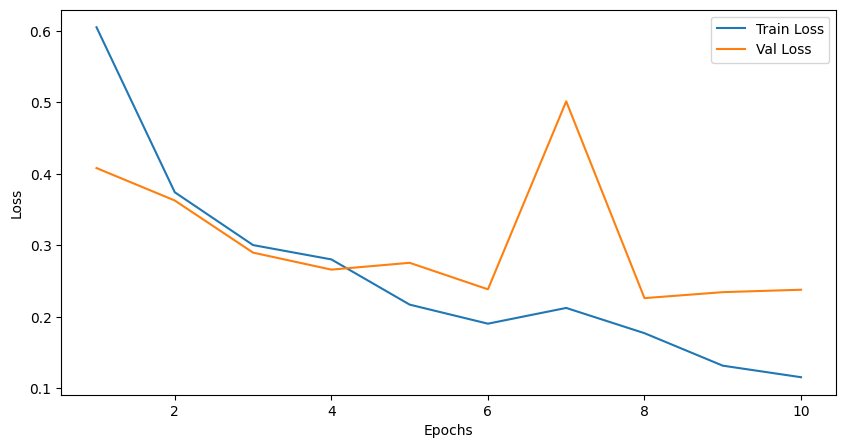

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, best_hyperparams["n_epochs"] + 1), train_losses, label="Train Loss")
plt.plot(range(1, best_hyperparams["n_epochs"] + 1), val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Primjecujemo da iako *Training loss* opada *Validation loss* raste nakon seste, sto nam sugeriSe da nam model potencijalno overfituje

In [19]:
lstm_model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_iterator:
        sequences, lengths = batch.body
        labels = batch.label
        predictions = lstm_model(sequences, lengths).squeeze()
        test_preds.extend(predictions.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())


# convert to binary predictions
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)

# metrics
accuracy = accuracy_score(test_labels, test_preds_binary)
precision = precision_score(test_labels, test_preds_binary)
recall = recall_score(test_labels, test_preds_binary)
f1 = f1_score(test_labels, test_preds_binary)
roc_auc = roc_auc_score(test_labels, test_preds)

# confusion matrix
cm = confusion_matrix(test_labels, test_preds_binary)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f'Test Accuracy: {accuracy*100:.2f}%')
print(f'Test Precision: {precision*100:.2f}%')
print(f'Test Recall: {recall*100:.2f}%')
print(f'Test F1 Score: {f1*100:.2f}%')
print(f'Test ROC AUC: {roc_auc*100:.2f}%')
print(f'False Positive Rate: {fpr*100:.2f}%')
print(f'False Negative Rate: {fnr*100:.2f}%')

Test Accuracy: 92.75%
Test Precision: 93.47%
Test Recall: 92.01%
Test F1 Score: 92.74%
Test ROC AUC: 97.75%
False Positive Rate: 6.50%
False Negative Rate: 7.99%
